# 0. Setup

## 0.1. libaries

In [1]:
'''standard imports'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime, timedelta, timezone

## 0.2. repo/data paths
**USABLE SYMBOLS:**

- `dirpath_repo` : str

(NOTE: You must hardcode this yourself)

In [2]:
dirpath_repo = r'C:\Users\Eris\Documents\sync_local\01_Research\wind'

## 0.3. `utils`
**USABLE FUNCTIONS:**
- `get_path` : -> str
- `print_dict` : -> print
- `printsep` : -> print
- `yq2dt` : str -> datetime
- `distance_km` : 2-tuple, 2-tuple -> float
- `unix_to_datetime` : int -> datetime

(usually this is it's own module, but we'll keep it simple for notebook drafting purposes)

In [3]:
'''utils'''

from typing import Union, List
from pathlib import Path

def get_path(*args: Union[str, List[str]]) -> str:
    """
    Join all arguments into a single path.
    
    Parameters:
        - Use 'current' to get the DIRECTORY CONTAINING this file (i.e. the file calling this function) is in.
            - NOTE: things get tricky when using notebooks -- if you want to get the directory of the file that called the function that called `get_path` (?), use `Path(__file__).resolve().parent` (I'm not even sure if that's correct, honestly). It's usually easier/safer to implement this functionality yourself, I can't guarantee this will work.
        - Use '..' to navigate to the parent directory.
    
    Returns:
        `pathlib` object
            Absolute path by joining all input components and resolving
        
    Example:
        If you're running a script/notebook in `/src/main/`, you can get the path to `/src/data/foo.txt` with:
            `get_path('current', '..', 'data', 'foo.txt')`            
    """
    parts = []
    for arg in args:
        if isinstance(arg, List):
            parts.extend(arg)
        else:
            parts.append(arg)

    # Replace 'current' with the current working directory
    parts = [Path.cwd() if part == 'current' else Path(part) for part in parts]
    
    # Join all parts and resolve to get the absolute path
    
    # return str(Path(*parts).resolve())
    return Path(*parts).resolve()




def print_dict(d: dict, indent=0, format_pastable=False, condense_arrays=True) -> None:
    """
    DESCRIPTION:
    ------------
        Cleaner way to print a dictionary, with option to condense numpy arrays.

    PARAMETERS:
    ------------
        d : dict
            The dictionary to print.
        indent : int
            The current indentation level.
        format_pastable : bool
            (Default False) If True, will format the output so that it can be directly pasted into Python code as an assignment to a variable. 
        condense_arrays : bool
            (Default True) If True, condenses numpy arrays into a shape descriptor rather than printing each element. 
    """
    for key, value in d.items():
        spacing = '\t' * indent
        key_repr = f"'{key}'" if isinstance(key, str) else key
        if isinstance(value, dict):
            print(f"{spacing}{key_repr}")
            print_dict(value, indent+1, format_pastable, condense_arrays)
        elif isinstance(value, np.ndarray) and condense_arrays:
            print(f"{spacing}{key_repr}")
            print(f"{spacing}\t<np.ndarray, shape={value.shape}>")
        elif format_pastable:
            value_repr = f"'{value}'" if isinstance(value, str) else value
            print(f"{spacing}{key_repr}: {value_repr!r},")
        else:
            value_repr = f"'{value}'" if isinstance(value, str) else value
            print(f"{spacing}{key_repr}")
            print(f"{spacing}\t{value_repr}")



def printsep(n=100):
    print()
    print('-' * n)
    print()



def yq2dt(year_quarter_str):
    '''Convert a 'year-quarter' string (e.g. 'Y2019Q1') to a datetime object. Note that this returns the first day of the quarter, even though the input is technically a range of dates.'''
    # Extract year and quarter
    year = int(year_quarter_str[1:5])
    quarter = int(year_quarter_str[-1])
    # Map quarter to the beginning month
    month = (quarter - 1) * 3 + 1
    # Create datetime object for the first day of the corresponding month
    return datetime(year, month, 1, tzinfo=timezone.utc)





def get_size(obj):
    '''Recursively find size of objects in bytes'''
    import sys
    if isinstance(obj, dict):
        return sum((get_size(v) for v in obj.values())) + sum((get_size(k) for k in obj.keys())) + sys.getsizeof(obj)
    elif isinstance(obj, list) or isinstance(obj, tuple) or isinstance(obj, set):
        return sum((get_size(i) for i in obj)) + sys.getsizeof(obj)
    elif isinstance(obj, np.ndarray):
        return obj.nbytes + sys.getsizeof(obj)
    else:
        return sys.getsizeof(obj)       




import cartopy.geodesic as gd
def distance_km(p1, p2):
    x, y, _ = gd.Geodesic().inverse(p1, p2)[0]
    return np.linalg.norm([x,y]) / 1.e3




def unix_to_datetime(unix_time_ms):
    '''Function to convert Unix timestamp (milliseconds) to a readable date'''
    return datetime.fromtimestamp(unix_time_ms / 1000, timezone.utc)



tab = '\t'

## 0.4. `owf_metadata`

**USABLE SYMBOLS:**
- `owf_metadata` : dict
    - We create the dict `owf_metadata`, whose KEYS are wind farm name, and VALUES are are fields described below:

**Description:**
- I made a CSV called owf_metadata.csv (available online [here](https://drive.google.com/drive/folders/1t4UKE1Xo6-_OaTlvJFUHIhXDvVkI99jU?usp=sharing)). For each wind farm, you have:
    - `name` (str) : 
        - name of wind farm (e.g. 'Hornsea Project One')
    - `lon`, `lat` (float) : 
        - longitude/latitude of the wind farm (approximate center)
            - source: wikipedia
    - `num_turbines` (int) : 
        - number of turbines in this wind farm
            - source: wikipedia
    - `capacity_mw` (float) : 
        - maximum amount of energy that can be produced in ideal conditions by the entire wind farm (in MW)
            - source: wikipedia
    - `start_operation_APPROX` (str / datetime) : 
        - approximate date when wind farm started operating at full capacity (warning: this is a very loose estimation based on random online sources)
            - source: manually inputted
        - note: in the dict this is converted to `datetime` object in place
    - `lon_left`, `lon_right`, `lat_bottom`, `lat_top` (float) : 
        - defines a bounding box around all turbines in the wind farm
            - source: manually inputted

In [4]:
'''
Metadata on various wind farms (coords, capacity, etc.)
    https://drive.google.com/drive/folders/1t4UKE1Xo6-_OaTlvJFUHIhXDvVkI99jU?usp=sharing
'''

owf_metadata = pd.read_csv(
    get_path(dirpath_repo, 'data', '1_raw', 'owf_metadata', 'owf_metadata.csv')
)


## formatting
owf_metadata['start_operation_APPROX'] = pd.to_datetime(owf_metadata['start_operation_APPROX'], format='%Y-%m-%d')
owf_metadata = owf_metadata.to_dict('index')
owf_metadata = {v['name']: v for k, v in owf_metadata.items()}

print_dict(owf_metadata)

'Hornsea Project One'
	'name'
		'Hornsea Project One'
	'lon'
		1.791111
	'lat'
		53.885
	'num_turbines'
		174
	'capacity_mw'
		1218
	'start_operation_APPROX'
		2019-02-01 00:00:00
	'lon_left'
		1.64
	'lon_right'
		2.25
	'lat_bottom'
		53.82
	'lat_top'
		53.98
'Horns Rev 3'
	'name'
		'Horns Rev 3'
	'lon'
		7.669167
	'lat'
		55.696944
	'num_turbines'
		49
	'capacity_mw'
		407
	'start_operation_APPROX'
		2019-08-22 00:00:00
	'lon_left'
		nan
	'lon_right'
		nan
	'lat_bottom'
		nan
	'lat_top'
		nan
'Horns Rev 1'
	'name'
		'Horns Rev 1'
	'lon'
		7.9833
	'lat'
		55.5333
	'num_turbines'
		80
	'capacity_mw'
		160
	'start_operation_APPROX'
		2002-12-11 00:00:00
	'lon_left'
		nan
	'lon_right'
		nan
	'lat_bottom'
		nan
	'lat_top'
		nan


## 0.5. `owt_locs`


**USABLE SYMBOLS:**
- `get_owt_locs`: fn -> numpy.ndarray, shape (N, 2), float
    - Accessor function for `owt_locs` dataframe (loaded from the DeepOWT dataset). 
    - Recommended to use this instead of directly accessing `owt_locs`, for convenience. 
-  `periods` : list(str)
    - Sorted list of periods (quarters) with data from DeepOWT.
-  `periods_dt` : list(datetime)
    - Same as `periods`, but in datetime format.

Extra:
- `owt_locs` : pandas.DataFrame
    - pandas.DataFrame where each row represents a turbine on the planet, and each column represents its operational status in a given quarter.
    - Recommended to use `get_owt_locs` instead of directly accessing `owt_locs`, for convenience. 

**Description of DeepOWT dataset (loaded into`owt_locs`):**
- Each column TITLE is a quarter:
    - start: 'Y2016Q3'
    - end: 'Y2021Q2'
    - (total 20 periods)
- Each column VALUE is an int representing the operational status of a turbine:
    - 0 = open sea
    - 1 = under construction
    - 2 = offshore wind turbine
    - 3 = offshore wind farm substation

In [5]:
'''Turbine coordinates'''

fpath_owts = get_path(dirpath_repo, 'data', '1_raw', 'owf_metadata', 'DeepOWT.geojson')

'''
[From Zenodo page https://zenodo.org/record/5933967, also in references.txt]:
    Mapping of integer values used in the dataset to semantic classes [e.g. "Y2016Q3"]

    INTEGER   |  SEMANTIC LABEL                 |  ABBREVIATION
    0         |  open sea                       |  sea
    1         |  under construction             |  const
    2         |  offshore wind turbine          |  owt
    3         |  offshore wind farm substation  |  sub
'''

## for some reason, the native geopandas read_file() function is disgustingly slow by a factor of 10-50x
## instead, we opt to manually load/format the json ourselves. this requires a bit of wrangling, but ultimately possible bc the geopandas geometry point objects are simply just 2-tuples

# import geopandas as gpd
# dat_owts = gpd.read_file(fpath_owts)


import json
with open(fpath_owts, 'r') as dat_nc_ocn:
    owt_locs = json.load(dat_nc_ocn)
owt_locs = owt_locs['features'] # this gives us a list of dictionaries, now we flatten the inner dictionaries

def transform_dict(dic):
    properties = dic.get('properties', {})
    coordinates = dic.get('geometry', {}).get('coordinates', [])
    new_dic = properties
    new_dic['coordinates'] = coordinates
    return new_dic
owt_locs = [transform_dict(dic) for dic in owt_locs]

owt_locs = pd.DataFrame(owt_locs)

# owt_locs

In [6]:
'''print options for periods'''

periods = owt_locs.keys().values.tolist()
periods.remove('coordinates')
periods.sort()

print('Period options:')
for period in periods:
    print(f"'{period}'")

periods_dt = [yq2dt(period) for period in periods]

Period options:
'Y2016Q3'
'Y2016Q4'
'Y2017Q1'
'Y2017Q2'
'Y2017Q3'
'Y2017Q4'
'Y2018Q1'
'Y2018Q2'
'Y2018Q3'
'Y2018Q4'
'Y2019Q1'
'Y2019Q2'
'Y2019Q3'
'Y2019Q4'
'Y2020Q1'
'Y2020Q2'
'Y2020Q3'
'Y2020Q4'
'Y2021Q1'
'Y2021Q2'


In [7]:
import bisect

def get_owt_locs(
    period = 'Y2021Q2', 
    status = 'operational', 
    lon_bounds = (-180,180), 
    lat_bounds = (-90,90), 
    suppress_warning = False,
):
    """
    DESCRIPTION:
    ------------
        Accessor function for DeepOWT dataset. Get coordinates of turbines in a specific region / period.
        Requires `owt_locs`, `periods`, and `periods_dt` defined in global scope. 
    
    
    PARAMETERS:
    ------------
        period : str or datetime
            Period of interest. Can either be a string in the format 'Y2019Q1' or a datetime object. Range is 'Y2016Q3' to 'Y2021Q2' with no gaps (i.e 20 options). 
            Default is most recent: 'Y2021Q2'.

        status : int or str
            Select operational status of turbine. Options are:
                - 0 or 'open sea'
                - 1 or 'under construction'
                - 2 or 'operational'
                - 3 or 'substation' (referring to offshore wind farm substation)
            Default is operational turbines (2).

        lon_bounds, lat_bounds : 2-tuple of floats
            Bounding box for visualization. Longitude in range [-180, 180], latitude in range [-90, 90].
            Default entire map.


    RETURN:
    ------------
        numpy.ndarray, shape (N, 2), float
            Array of turbine coordinates, where N is number of turbines, and each row is a (lon, lat) pair.

            
    REFERENCES:
    ------------
        [see 'docs/references.txt' for more information...]

        Coordinates of all offshore wind turbines:
            - Zenodo dataset:
                > Hoeser, Thorsten, & Kuenzer, Claudia. (2022). DeepOWT: A global offshore wind turbine data set [Data set]. In Earth System Science Data (1.21.2, Vol. 14, pp. 4251–4270). Zenodo. https://doi.org/10.5281/zenodo.5933967
            - Original publication:
                > Hoeser, T., Feuerstein, S., & Kuenzer, C. (2022). DeepOWT: A global offshore wind turbine data set derived with deep learning from sentinel-1 data. Earth System Science Data, 14(9), 4251–4270. https://doi.org/10.5194/essd-14-4251-2022 
    """

    '''ARG HANDLING'''

    ## check coordinate bounds
    if not all(-180 <= lon <= 180 for lon in lon_bounds):
        raise ValueError(f'Longitude bounds {lon_bounds} are not in range [-180, 180].')
    if not all(-180 <= lat <= 180 for lat in lat_bounds):
        raise ValueError(f'Latitude bounds {lat_bounds} are not in range [-90, 90].')
    
    ## if period is datetime, convert to string
    if isinstance(period, datetime):
        if period < periods_dt[0]:
            raise ValueError(f'The inputted date {period.strftime("%Y-%m-%d")} is earlier than DeepOWT\'s first period ({periods_dt[0].strftime("%Y-%m-%d")}).')
        elif period > periods_dt[-1]:
            period = periods[-1]
            if not suppress_warning:
                print(f'WARNING: the inputted date is later than DeepOWT\'s last period. Defaulting to most recent period {period}. Use `suppress_warning=True` to suppress this message.')
        else:
            for i, val in enumerate(periods_dt):
                if period < val:
                    period = periods[i-1]
                    break

    if period not in periods:
        raise ValueError(f'Invalid period {period}. Valid options are {periods}.')


    ## if status is string, convert to int code
    statuses = ['open sea', 'under construction', 'operational', 'substation']

    if isinstance(status, int) and not(0<=status<=3):
        raise ValueError(f"Invalid status '{status}'. Valid options are {statuses} or 0-3.")
    elif isinstance(status, str):
        if status not in statuses:
            raise ValueError(f"Invalid status '{status}'. Valid options are {statuses} or 0-3.")
        status = statuses.index(status)




    '''GET TURBINE COORDINATES'''
        

    '''step 1/2: find turbines operational in the given period'''

    ## limit database to turbines which were operational during the specified period
    owt_locs_thisPeriod = owt_locs[owt_locs[period] == status] 
    ## convert to Nx2 numpy array of (lon,lat)
    owt_locs_thisPeriod = np.array(owt_locs_thisPeriod['coordinates'].tolist()) 



    '''step 2/2: find turbines within the chosen boundaries'''

    bounded_indices = np.where(
        (lon_bounds[0] <= owt_locs_thisPeriod[:,0]                 ) &
        (                 owt_locs_thisPeriod[:,0] <= lon_bounds[1]) &
        (lat_bounds[0] <= owt_locs_thisPeriod[:,1]                 ) &
        (                 owt_locs_thisPeriod[:,1] <= lat_bounds[1])
    )
    owt_locs_thisPeriod = owt_locs_thisPeriod[bounded_indices]


    return owt_locs_thisPeriod

## ~~0.6. Choose a Wind Farm and Add Turbine Coordinates (i.e. combine `owf_metadata` and `owt_locs`)~~

**USABLE SYMBOLS:**
- `this_owf` : dict
    - Identical to a sub-dictionary of `owf_metadata`, but with the addition of a 'turbine_coords' key, which itself is a dictionary where keys are year-quarters (e.g. 'Y2020Q4') and values are numpy.ndarrays of shape (N,2) where N is the number of turbines in the wind farm, and the 2 columns are longitude and latitude of each turbine.

**Note:**
- The old method of manually filtering turbine locations by farm/period is [here](https://gist.github.com/Humboldt-Penguin/201661f003f991cb40ae4456dbdd5ccd).


Depracated symbol:
- `owt_locs_thisPeriod` : numpy.ndarray
    - Nx2 array of turbine locations (lon,lat) for a given period

---
# Summary of usable functions/variables (0. Setup)

```
- helper functions
    - `get_path`         : (fn) *args -> str
    - `print_dict`       : (fn) -> (print)
    - `printsep`         : (fn) -> (print)
    - `yq2dt`            : (fn) str -> datetime
    - `distance_km`      : (fn) 2-tuple, 2-tuple -> float
    - `unix_to_datetime` : (fn) int -> datetime
- system
    - `dirpath_repo`     : str
- data
    - `this_owf`         : dict
        - `periods`      : list(str)
        - `periods_dt`   : list(datetime)
    - `get_owt_locs`     : (fn) *args -> numpy.ndarray, shape (N, 2), float
```

<!---
| CATEGORY | VAR_NAME | TYPE |
| --- | --- | --- |
| helper functions | `get_path` | fn -> str |
| ^ | `print_dict` | fn -> print |
| ^ | `printsep` | fn -> print |
| system | `dirpath_repo` | str |
| data | `this_owf` | dict |
| ^ | `owt_locs` | pandas.DataFrame |
-->

---
# 1. ue ue ue

In [14]:
"""NOTE: choose wind farm"""

'''manual apriori input (get these values from wikipedia)'''
this_owf = {
    'name': 'Anholt',
    'lon': 11.21000,
    'lat': 56.60000,
    'num_turbines': 111,
}


# '''from csv'''
# name = 'Horns Rev 3'
# this_owf = owf_metadata[name]



In [9]:
'''geographic plotting'''
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

Found 111 turbines in given bounds.
csv_lon_left = 11.138047760159056
csv_lon_right = 11.33312940903395
csv_lat_bottom = 56.49802887413224
csv_lat_top = 56.71224463855888


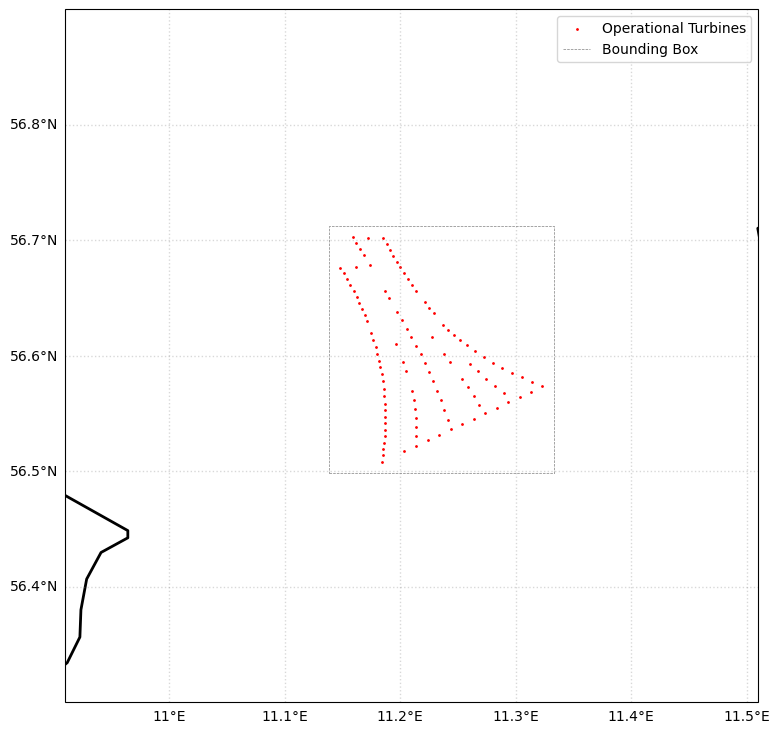

In [24]:
'''init plot'''

fig = plt.figure(figsize=(16, 9))
ax = plt.axes(projection=ccrs.PlateCarree())



'''axes limits'''

padding_deg = 0.3

plot_lon_bounds = [ this_owf['lon']  -padding_deg,   this_owf['lon']  +padding_deg ]
plot_lat_bounds = [ this_owf['lat']  -padding_deg,   this_owf['lat']  +padding_deg ]

ax.set_xlim(plot_lon_bounds)
ax.set_ylim(plot_lat_bounds)

# ax.set_xlim((this_owf['lon_left']-padding_deg, this_owf['lon_right']+padding_deg))
# ax.set_ylim((this_owf['lat_bottom']-padding_deg, this_owf['lat_top']+padding_deg))





'''grid + ticks'''

ax_grid = ax.gridlines(
    crs=ccrs.PlateCarree(), draw_labels=True,
    linewidth=1, color='gray', alpha=0.3, linestyle=':'
)

ax_grid.xformatter = LONGITUDE_FORMATTER
ax_grid.yformatter = LATITUDE_FORMATTER

ax_grid.top_labels = False
ax_grid.right_labels = False





'''layer 1: turbines'''

padding_farm = 0.15
farm_lon_bounds = [ this_owf['lon'] - padding_farm , this_owf['lon'] + padding_farm ]
farm_lat_bounds = [ this_owf['lat'] - padding_farm , this_owf['lat'] + padding_farm ]

turbine_coords = get_owt_locs(
    period = periods[-1], 
    status = 'operational', 
    lon_bounds = farm_lon_bounds, 
    lat_bounds = farm_lat_bounds, 
)

print(f'Found {turbine_coords.shape[0]} turbines in given bounds.')


ax_turbine_scatter = ax.scatter(
    x = turbine_coords[:,0],
    y = turbine_coords[:,1],
    transform = ccrs.PlateCarree(),
    s = 1,
    color = 'red', 
    label = 'Operational Turbines'
)

ax.legend(loc='upper right')




'''layer 2: bounding box'''

bounding_box_padding = 0.01
csv_lon_left   = turbine_coords[:,0].min() - bounding_box_padding
csv_lon_right  = turbine_coords[:,0].max() + bounding_box_padding
csv_lat_bottom = turbine_coords[:,1].min() - bounding_box_padding
csv_lat_top    = turbine_coords[:,1].max() + bounding_box_padding

print(f'{csv_lon_left = }')
print(f'{csv_lon_right = }')
print(f'{csv_lat_bottom = }')
print(f'{csv_lat_top = }')

ax_bounding_box = ax.plot(
    [csv_lon_left, csv_lon_right, csv_lon_right, csv_lon_left, csv_lon_left],
    [csv_lat_bottom, csv_lat_bottom, csv_lat_top, csv_lat_top, csv_lat_bottom],
    transform = ccrs.PlateCarree(),
    color = 'black',
    alpha = 0.5,
    linestyle = '--',
    linewidth = 0.5,
    label = 'Bounding Box'
)





'''layer -1: coastlines'''

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='white', facecolor='white')) # white-out data on land masses
ax.coastlines(resolution='10m', linewidth=2, color='black') # draw coastlines




'''titles'''

# ax.set_title(f'{dat_ocn["time"].strftime("%Y-%m-%d")}')
plt.legend(loc='upper right')


plt.show()